# Creating A XGBOOST MODEL 


## Loading and Cleaning the Data
first of all we will load our datasets and clean them.

In [26]:
# Loading Packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt



In [27]:
# Loading the data
att_v2 = pd.read_excel("FVIII_attributes_v2.xlsx", sheet_name = "FVIII_attributes")
att_v2.head()

,AA_HGVS,Residue,Domain,relSESA,consurf_old,dg,bt,cl,auth,kcore
0,20,A,A1,1.039415,-0.438,2,0.000000,0.111791,0.018996,2
1,21,T,A1,0.801030,-0.496,3,0.000000,0.113146,0.040660,3
2,22,R,A1,0.499384,-0.784,10,0.005384,0.119778,0.105625,5
3,23,R,A1,0.822534,0.278,3,0.000731,0.111507,0.034230,2
4,24,Y,A1,0.371264,0.087,10,0.003627,0.121302,0.156471,5


In [28]:
patients_data = pd.read_excel("FVIII_discrepant_mutations.xlsx", sheet_name = "Unique_mutations")
patients_data.head()


,AA_HGVS,domain,AA_change,mild,moderate,severe,discrepancy
0,23,A1,p.(Arg23Gly),4,0,0,No
1,27,A1,p.(Gly27Asp),0,1,1,Yes
2,28,A1,p.(Ala28Lys),0,1,0,No
3,29,A1,p.(Val29Gly),0,0,1,No
4,31,A1,p.(Leu31Pro),0,1,0,No


In [29]:
pat_attr = pd.merge(patients_data, att_v2, on = "AA_HGVS", how = "left")
print(pat_attr.head())

   AA_HGVS domain     AA_change  mild  moderate  severe discrepancy Residue  \
0       23     A1  p.(Arg23Gly)     4         0       0          No       R   
1       27     A1  p.(Gly27Asp)     0         1       1         Yes       G   
2       28     A1  p.(Ala28Lys)     0         1       0          No       A   
3       29     A1  p.(Val29Gly)     0         0       1          No       V   
4       31     A1  p.(Leu31Pro)     0         1       0          No       L   

  Domain   relSESA  consurf_old   dg        bt        cl      auth  kcore  
0     A1  0.822534        0.278  3.0  0.000731  0.111507  0.034230    2.0  
1     A1  0.000000       -0.661  5.0  0.000846  0.115499  0.068212    5.0  
2     A1  0.000000       -1.019  7.0  0.001244  0.118282  0.097886    5.0  
3     A1  0.207992       -0.746  9.0  0.001465  0.112729  0.095604    5.0  
4     A1  0.250858       -0.134  7.0  0.006061  0.117071  0.074920    4.0  


In [30]:
# Extract the original amino acid, position, and new amino acid from the AA_change column
pat_attr["original_AA"] = pat_attr["AA_change"].str.extract(r"\((\w{3})\d+\w{3}\)")
pat_attr["new_AA"] = pat_attr["AA_change"].str.extract(r"\(\w{3}\d+(\w{3})\)")

# Drop the AA_change column
pat_attr = pat_attr.drop(columns = ["AA_change", "Domain", "mild", "moderate", "severe"])

In [31]:
pat_attr = pat_attr.replace(to_replace = ['Yes','No'], value = ['1','0'])

In [32]:
pat_attr['discrepancy'] = pat_attr['discrepancy'].astype(int)

In [33]:
pat_attr.dtypes

AA_HGVS          int64
domain          object
discrepancy      int32
Residue         object
relSESA        float64
consurf_old    float64
dg             float64
bt             float64
cl             float64
auth           float64
kcore          float64
original_AA     object
new_AA          object
dtype: object

## Checking for missing values

In [34]:
pd.isnull(pat_attr).sum()

AA_HGVS         0
domain          0
discrepancy     0
Residue        48
relSESA        48
consurf_old    48
dg             48
bt             48
cl             48
auth           48
kcore          48
original_AA     0
new_AA          0
dtype: int64

In [35]:
pat_attr = pat_attr.dropna()

In [36]:
pd.isnull(pat_attr).sum()

AA_HGVS        0
domain         0
discrepancy    0
Residue        0
relSESA        0
consurf_old    0
dg             0
bt             0
cl             0
auth           0
kcore          0
original_AA    0
new_AA         0
dtype: int64

## Splitting the columns into dependent and independent variables 

In [37]:
X = pat_attr.drop("discrepancy", axis = 1).copy()
X.head()

,AA_HGVS,domain,Residue,relSESA,consurf_old,dg,bt,cl,auth,kcore,original_AA,new_AA
0,23,A1,R,0.822534,0.278,3.0,0.000731,0.111507,0.034230,2.0,Arg,Gly
1,27,A1,G,0.000000,-0.661,5.0,0.000846,0.115499,0.068212,5.0,Gly,Asp
2,28,A1,A,0.000000,-1.019,7.0,0.001244,0.118282,0.097886,5.0,Ala,Lys
3,29,A1,V,0.207992,-0.746,9.0,0.001465,0.112729,0.095604,5.0,Val,Gly
4,31,A1,L,0.250858,-0.134,7.0,0.006061,0.117071,0.074920,4.0,Leu,Pro


In [38]:
y = pat_attr["discrepancy"].copy()
y.head()

0    0
1    1
2    0
3    0
4    0
Name: discrepancy, dtype: int32

In [39]:
y.unique()

array([0, 1])

## Creating one hot encoding

In [40]:
# Create an empty array to store the column names
obj_columns = []

# Loop through the columns of the dataframe
for col in X.columns:
    # Check if the column is an object
    if X[col].dtype == "object":
        # Save the column name to the array
        obj_columns.append(col)

# Print the array
print(obj_columns)

['domain', 'Residue', 'original_AA', 'new_AA']


In [41]:
X_encoded = pd.get_dummies(X, columns= obj_columns)
X_encoded.head()

,AA_HGVS,relSESA,consurf_old,dg,bt,cl,auth,kcore,domain_A1,domain_A1,...,new_AA_Leu,new_AA_Lys,new_AA_Met,new_AA_Phe,new_AA_Pro,new_AA_Ser,new_AA_Thr,new_AA_Trp,new_AA_Tyr,new_AA_Val
0,23,0.822534,0.278,3.0,0.000731,0.111507,0.034230,2.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,27,0.000000,-0.661,5.0,0.000846,0.115499,0.068212,5.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,28,0.000000,-1.019,7.0,0.001244,0.118282,0.097886,5.0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,29,0.207992,-0.746,9.0,0.001465,0.112729,0.095604,5.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,31,0.250858,-0.134,7.0,0.006061,0.117071,0.074920,4.0,1,0,...,0,0,0,0,1,0,0,0,0,0


## Preliminary XGBOOST MODEL

In [42]:
sum(y)/len(y)

0.17559523809523808

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify= y)

In [44]:
sum(y_train)/len(y_train)

0.1746031746031746

In [45]:
sum(y_test) / len(y_test) 

0.17857142857142858

Confusion Matrix:
 [[65  4]
 [15  0]]


C:\Users\hajam\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


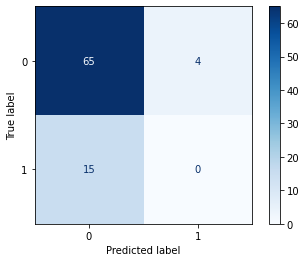

In [46]:

# Define the xgboost model with the best parameters from grid search
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = "auc", random_state = 42, n_estimators=200, max_depth=5, learning_rate=0.1)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Predict the test set labels using the fitted model
y_pred = xgb_model.predict(X_test)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
plot_confusion_matrix(xgb_model, X_test, y_test, cmap = "Blues")

## Fine Tuning the model 

Best parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.5}
Best score:  0.5685346496322106
Confusion Matrix:
 [[62  7]
 [15  0]]


C:\Users\hajam\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


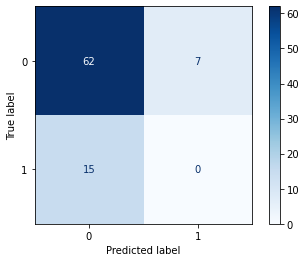

In [47]:
# Define the parameter grid for grid search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.5, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}

# Define the grid search object
grid_search = GridSearchCV(xgb_model, param_grid, cv = 5, scoring = make_scorer(roc_auc_score), n_jobs = -1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Predict the test set labels using the fitted model
y_pred_xgb = grid_search.predict(X_test)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
plot_confusion_matrix(grid_search, X_test, y_test, cmap = "Blues")

In [49]:
bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print("XGBoost Balanced Accuracy Score:", bal_acc_xgb)

XGBoost Balanced Accuracy Score: 0.4492753623188406


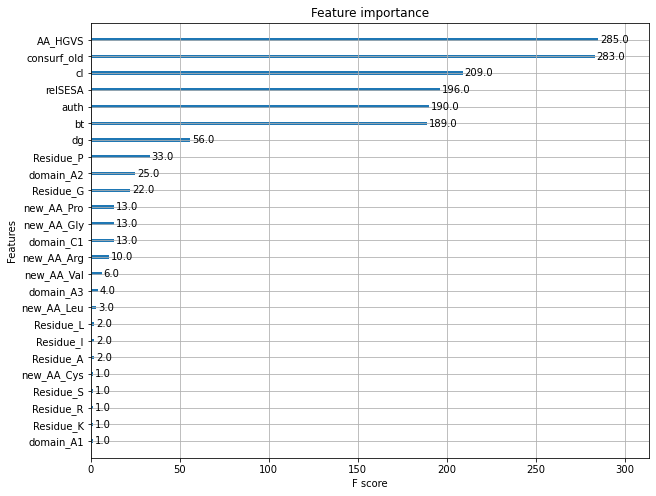

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_model, ax=ax)
plt.show()

## Creating a logistic regression model

In [51]:
lr_model = LogisticRegression(random_state=42)

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Predict the test set labels using the fitted model
y_pred_lr = lr_model.predict(X_test)

# Calculate and print the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Logistic Regression Confusion Matrix:\n", cm_lr)

# Calculate the balanced accuracy score and print it
bal_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Balanced Accuracy Score:", bal_acc_lr)

Logistic Regression Confusion Matrix:
 [[69  0]
 [15  0]]
Logistic Regression Balanced Accuracy Score: 0.5


C:\Users\hajam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
